# Performance Optimization for shreamy

This notebook investigates performance bottlenecks in shreamy and explores optimization strategies.

## Goals
1. Profile the orbit integration to identify bottlenecks
2. Analyze where time is spent (integrator vs potential evaluation)
3. Identify optimization opportunities
4. Implement and benchmark improvements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import cProfile
import pstats
import io
from pstats import SortKey

# shreamy imports
from shreamy.potentials import NFWPotential, PlummerPotential
from shreamy.integrators import Leapfrog
from shreamy.gravity import DirectSummation

# For comparison
from galpy.potential import NFWPotential as galpy_NFW
from galpy.orbit import Orbit

print("Imports complete")

Imports complete


## 1. Setup Test Case: Orbit in External Potential

We'll use the same setup as the demo notebook - a single particle orbiting in an NFW halo.

In [2]:
# Setup NFW potential
M_s = 1.0  # Scale mass
r_s = 0.2  # Scale radius
nfw = NFWPotential(M_s=M_s, r_s=r_s)

# Initial conditions
R_init = 1.0
z_init = 0.1
vR_init = 0.1
vT_init = np.atleast_1d(nfw.circular_velocity(R_init))[0] * 0.9
vz_init = 0.05

# Integration parameters
t_end = 50.0
n_steps = 5000
times = np.linspace(0, t_end, n_steps + 1)

# Initial position/velocity arrays
pos_init = np.array([[R_init, 0.0, z_init]])
vel_init = np.array([[vR_init, vT_init, vz_init]])

print(f"Test case: NFW potential, {n_steps} steps")
print(f"Initial conditions: R={R_init}, z={z_init}, vT={vT_init:.4f}")

Test case: NFW potential, 5000 steps
Initial conditions: R=1.0, z=0.1, vT=0.8811


## 2. Profile the Current Implementation

Use cProfile to identify where time is being spent.

In [3]:
# Define acceleration function
def shreamy_acc(pos, vel, t):
    x, y, z = pos[:, 0], pos[:, 1], pos[:, 2]
    return nfw.acceleration(x, y, z, t)

integrator = Leapfrog(shreamy_acc)

# Profile the integration
profiler = cProfile.Profile()
profiler.enable()

_, saved_pos, saved_vel = integrator.integrate(
    pos_init, vel_init, times, save_every=n_steps, progressbar=False
)

profiler.disable()

# Print profiling results
s = io.StringIO()
ps = pstats.Stats(profiler, stream=s).sort_stats(SortKey.CUMULATIVE)
ps.print_stats(20)
print(s.getvalue())

         335060 function calls in 0.165 seconds

   Ordered by: cumulative time
   List reduced from 37 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.165    0.083 /Users/gabrielpfaffman/Repos/shreamy/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3514(run_code)
        2    0.000    0.000    0.165    0.082 {built-in method builtins.exec}
        1    0.000    0.000    0.165    0.165 /var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_2224/59964035.py:12(<module>)
        1    0.003    0.003    0.165    0.165 /Users/gabrielpfaffman/Repos/shreamy/shreamy/integrators/leapfrog.py:81(integrate)
     5000    0.015    0.000    0.162    0.000 /Users/gabrielpfaffman/Repos/shreamy/shreamy/integrators/leapfrog.py:40(step)
    10000    0.008    0.000    0.147    0.000 /var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_2224/59964035.py:2(shreamy_acc)
    10000    0.094    0.0

In [4]:
# Also show by total time spent in each function (excluding subcalls)
s2 = io.StringIO()
ps2 = pstats.Stats(profiler, stream=s2).sort_stats(SortKey.TIME)
ps2.print_stats(20)
print("\nSorted by time spent in function (tottime):")
print(s2.getvalue())


Sorted by time spent in function (tottime):
         335060 function calls in 0.165 seconds

   Ordered by: internal time
   List reduced from 37 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10000    0.094    0.000    0.139    0.000 /Users/gabrielpfaffman/Repos/shreamy/shreamy/potentials/nfw.py:125(acceleration)
    10000    0.018    0.000    0.025    0.000 /Users/gabrielpfaffman/Repos/shreamy/.venv/lib/python3.9/site-packages/numpy/lib/_shape_base_impl.py:622(column_stack)
     5000    0.015    0.000    0.162    0.000 /Users/gabrielpfaffman/Repos/shreamy/shreamy/integrators/leapfrog.py:40(step)
    30001    0.010    0.000    0.013    0.000 /Users/gabrielpfaffman/Repos/shreamy/.venv/lib/python3.9/site-packages/numpy/_core/shape_base.py:23(atleast_1d)
    10000    0.008    0.000    0.147    0.000 /var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_2224/59964035.py:2(shreamy_acc)
    30000    0.004    0.000    0.004   

## 3. Breakdown: Integrator vs Potential Evaluation

Let's measure how much time is spent in each component.

In [5]:
# Time just the acceleration function
n_calls = 10000
test_pos = np.array([[1.0, 0.5, 0.1]])
test_vel = np.array([[0.1, 0.8, 0.05]])

# Warm up
for _ in range(100):
    _ = shreamy_acc(test_pos, test_vel, 0.0)

# Time acceleration calls
start = time.perf_counter()
for _ in range(n_calls):
    _ = shreamy_acc(test_pos, test_vel, 0.0)
acc_time = time.perf_counter() - start

print(f"Acceleration function: {n_calls} calls in {acc_time:.4f}s")
print(f"  Per call: {acc_time/n_calls*1e6:.2f} µs")
print(f"  For {n_steps} steps (2 acc calls each): {2*n_steps * acc_time/n_calls:.4f}s estimated")

Acceleration function: 10000 calls in 0.1187s
  Per call: 11.87 µs
  For 5000 steps (2 acc calls each): 0.1187s estimated


In [6]:
# Time the full integration
n_repeats = 5
times_list = []

for _ in range(n_repeats):
    start = time.perf_counter()
    _, _, _ = integrator.integrate(
        pos_init, vel_init, times, save_every=n_steps, progressbar=False
    )
    times_list.append(time.perf_counter() - start)

total_time = np.median(times_list)
print(f"\nFull integration: {total_time:.4f}s (median of {n_repeats} runs)")
print(f"Estimated acceleration time: {2*n_steps * acc_time/n_calls:.4f}s")
print(f"Estimated overhead (integrator): {total_time - 2*n_steps * acc_time/n_calls:.4f}s")
print(f"\nBreakdown:")
print(f"  Acceleration: {100 * 2*n_steps * acc_time/n_calls / total_time:.1f}%")
print(f"  Integrator overhead: {100 * (1 - 2*n_steps * acc_time/n_calls / total_time):.1f}%")


Full integration: 0.1291s (median of 5 runs)
Estimated acceleration time: 0.1187s
Estimated overhead (integrator): 0.0105s

Breakdown:
  Acceleration: 91.9%
  Integrator overhead: 8.1%


## 4. Detailed Analysis of NFW Acceleration

Let's break down what's happening inside the acceleration calculation.

In [7]:
# Profile just the NFW acceleration
profiler2 = cProfile.Profile()
profiler2.enable()

for _ in range(n_calls):
    _ = nfw.acceleration(test_pos[:, 0], test_pos[:, 1], test_pos[:, 2], 0.0)

profiler2.disable()

s3 = io.StringIO()
ps3 = pstats.Stats(profiler2, stream=s3).sort_stats(SortKey.CUMULATIVE)
ps3.print_stats(15)
print("NFW acceleration breakdown:")
print(s3.getvalue())

NFW acceleration breakdown:
         320043 function calls in 0.145 seconds

   Ordered by: cumulative time
   List reduced from 32 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.145    0.073 /Users/gabrielpfaffman/Repos/shreamy/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3514(run_code)
        2    0.000    0.000    0.145    0.073 {built-in method builtins.exec}
        1    0.009    0.009    0.145    0.145 /var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_2224/3047220465.py:5(<module>)
    10000    0.093    0.000    0.137    0.000 /Users/gabrielpfaffman/Repos/shreamy/shreamy/potentials/nfw.py:125(acceleration)
    10000    0.018    0.000    0.024    0.000 /Users/gabrielpfaffman/Repos/shreamy/.venv/lib/python3.9/site-packages/numpy/lib/_shape_base_impl.py:622(column_stack)
    30000    0.010    0.000    0.013    0.000 /Users/gabrielpfaffman/Repos/shreamy/.venv/lib/p

## 5. Analyze Leapfrog Integrator Overhead

Let's look at what the integrator is doing besides calling the acceleration function.

In [8]:
# Create a minimal acceleration function to isolate integrator overhead
def minimal_acc(pos, vel, t):
    """Minimal acceleration - just return zeros"""
    return np.zeros_like(pos)

minimal_integrator = Leapfrog(minimal_acc)

# Time with minimal acceleration
times_minimal = []
for _ in range(n_repeats):
    start = time.perf_counter()
    _, _, _ = minimal_integrator.integrate(
        pos_init, vel_init, times, save_every=n_steps, progressbar=False
    )
    times_minimal.append(time.perf_counter() - start)

overhead_time = np.median(times_minimal)
print(f"Integrator with zero-acceleration: {overhead_time:.4f}s")
print(f"Full integration time: {total_time:.4f}s")
print(f"Time in acceleration: {total_time - overhead_time:.4f}s")
print(f"\nPercentage breakdown:")
print(f"  Integrator overhead: {100*overhead_time/total_time:.1f}%")
print(f"  Acceleration evaluation: {100*(total_time-overhead_time)/total_time:.1f}%")

Integrator with zero-acceleration: 0.0228s
Full integration time: 0.1291s
Time in acceleration: 0.1063s

Percentage breakdown:
  Integrator overhead: 17.7%
  Acceleration evaluation: 82.3%


In [9]:
# Profile the integrator step function
profiler3 = cProfile.Profile()
profiler3.enable()

pos = pos_init.copy()
vel = vel_init.copy()
dt = times[1] - times[0]

for i in range(1000):
    pos, vel = integrator.step(pos, vel, i*dt, dt)

profiler3.disable()

s4 = io.StringIO()
ps4 = pstats.Stats(profiler3, stream=s4).sort_stats(SortKey.CUMULATIVE)
ps4.print_stats(20)
print("Leapfrog step breakdown (1000 steps):")
print(s4.getvalue())

Leapfrog step breakdown (1000 steps):
         67108 function calls in 0.041 seconds

   Ordered by: cumulative time
   List reduced from 38 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        5    0.000    0.000    0.041    0.008 /Users/gabrielpfaffman/Repos/shreamy/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3514(run_code)
        5    0.000    0.000    0.041    0.008 {built-in method builtins.exec}
        1    0.001    0.001    0.041    0.041 /var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_2224/2140527999.py:9(<module>)
     1000    0.004    0.000    0.041    0.000 /Users/gabrielpfaffman/Repos/shreamy/shreamy/integrators/leapfrog.py:40(step)
     2000    0.002    0.000    0.037    0.000 /var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_2224/59964035.py:2(shreamy_acc)
     2000    0.023    0.000    0.035    0.000 /Users/gabrielpfaffman/Repos/shreamy/shreamy/potentials/nfw.py:125(acc

## 6. Comparison with galpy

Let's see where galpy spends its time.

In [10]:
# Setup galpy
galpy_nfw = galpy_NFW(amp=M_s, a=r_s, ro=1.0, vo=1.0)

# Profile galpy Python leapfrog
profiler4 = cProfile.Profile()
profiler4.enable()

o = Orbit([R_init, vR_init, vT_init, z_init, vz_init, 0.0], ro=1.0, vo=1.0)
o.integrate(times, galpy_nfw, method='leapfrog')

profiler4.disable()

s5 = io.StringIO()
ps5 = pstats.Stats(profiler4, stream=s5).sort_stats(SortKey.CUMULATIVE)
ps5.print_stats(20)
print("galpy Python leapfrog breakdown:")
print(s5.getvalue())

galpy Python leapfrog breakdown:
         320549 function calls (320546 primitive calls) in 0.191 seconds

   Ordered by: cumulative time
   List reduced from 124 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000    0.191    0.064 /Users/gabrielpfaffman/Repos/shreamy/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3514(run_code)
        3    0.000    0.000    0.191    0.064 {built-in method builtins.exec}
        1    0.000    0.000    0.191    0.191 /var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_2224/3039360171.py:9(<module>)
        1    0.000    0.000    0.191    0.191 /Users/gabrielpfaffman/Repos/shreamy/.venv/lib/python3.9/site-packages/galpy/orbit/Orbits.py:1396(integrate)
        1    0.000    0.000    0.190    0.190 /Users/gabrielpfaffman/Repos/shreamy/.venv/lib/python3.9/site-packages/galpy/orbit/integrateFullOrbit.py:784(integrateFullOrbit)
        1    0.000    0.0

## 7. Summary and Optimization Opportunities

Based on the profiling, identify the main bottlenecks and potential optimizations.

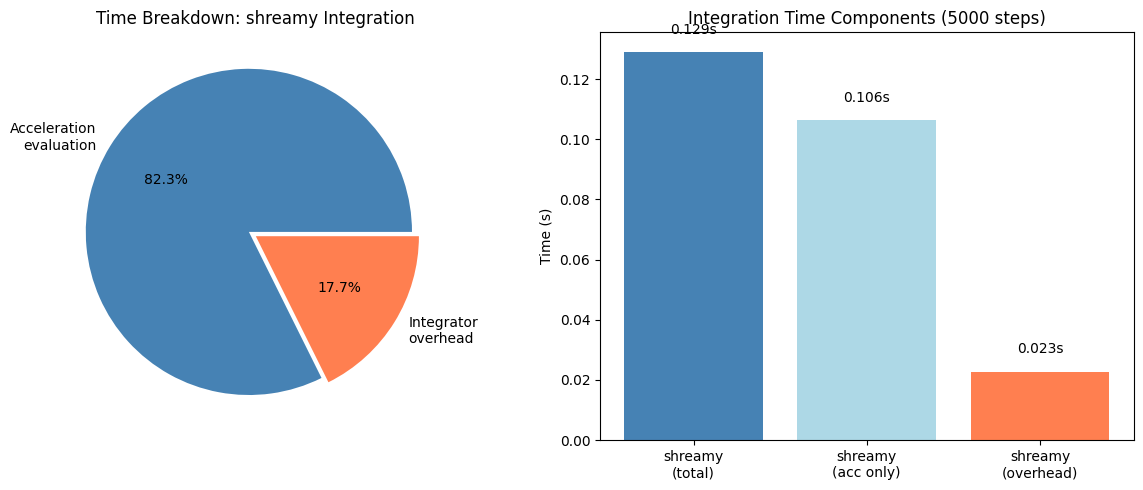


OPTIMIZATION OPPORTUNITIES

1. Acceleration evaluation: 82.3% of total time
   - NumPy operations (sqrt, log1p, division)
   - Array creation overhead (atleast_1d, column_stack)
   - Potential: Numba JIT, Cython, or C extension

2. Integrator overhead: 17.7% of total time
   - Python function call overhead
   - Array operations in step()
   - Potential: Vectorize multiple steps, Numba JIT


In [11]:
# Summary visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart of time breakdown
ax1 = axes[0]
acc_pct = 100 * (total_time - overhead_time) / total_time
overhead_pct = 100 * overhead_time / total_time
ax1.pie([acc_pct, overhead_pct], 
        labels=['Acceleration\nevaluation', 'Integrator\noverhead'],
        autopct='%1.1f%%', colors=['steelblue', 'coral'],
        explode=[0.05, 0])
ax1.set_title('Time Breakdown: shreamy Integration')

# Bar chart comparing times
ax2 = axes[1]
categories = ['shreamy\n(total)', 'shreamy\n(acc only)', 'shreamy\n(overhead)']
values = [total_time, total_time - overhead_time, overhead_time]
colors = ['steelblue', 'lightblue', 'coral']
bars = ax2.bar(categories, values, color=colors)
ax2.set_ylabel('Time (s)')
ax2.set_title(f'Integration Time Components ({n_steps} steps)')
for bar, val in zip(bars, values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{val:.3f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("OPTIMIZATION OPPORTUNITIES")
print("="*60)
print(f"\n1. Acceleration evaluation: {acc_pct:.1f}% of total time")
print("   - NumPy operations (sqrt, log1p, division)")
print("   - Array creation overhead (atleast_1d, column_stack)")
print("   - Potential: Numba JIT, Cython, or C extension")
print(f"\n2. Integrator overhead: {overhead_pct:.1f}% of total time")
print("   - Python function call overhead")
print("   - Array operations in step()")
print("   - Potential: Vectorize multiple steps, Numba JIT")

## 8. Line-by-Line Analysis of NFW Acceleration

Let's break down exactly where time is spent in the acceleration function by timing each operation.

In [12]:
# Micro-benchmark each operation in the acceleration function
n_micro = 100000

x = np.array([1.0])
y = np.array([0.5])
z = np.array([0.1])

# Store timings
timings = {}

# 1. atleast_1d calls (3x)
start = time.perf_counter()
for _ in range(n_micro):
    _ = np.atleast_1d(x)
    _ = np.atleast_1d(y)
    _ = np.atleast_1d(z)
timings['atleast_1d (3x)'] = time.perf_counter() - start

# 2. sqrt for r
start = time.perf_counter()
for _ in range(n_micro):
    r = np.sqrt(x**2 + y**2 + z**2)
timings['sqrt + squares'] = time.perf_counter() - start

# 3. np.where for r_safe
start = time.perf_counter()
for _ in range(n_micro):
    r_safe = np.where(r > 0, r, 1.0)
timings['np.where (r_safe)'] = time.perf_counter() - start

# 4. Division for u
r_s = 0.2
start = time.perf_counter()
for _ in range(n_micro):
    u = r_safe / r_s
timings['division (u)'] = time.perf_counter() - start

# 5. log1p
start = time.perf_counter()
for _ in range(n_micro):
    log_term = np.log1p(u)
timings['log1p'] = time.perf_counter() - start

# 6. bracket calculation
start = time.perf_counter()
for _ in range(n_micro):
    bracket = np.log1p(u) - u / (1 + u)
timings['bracket calc'] = time.perf_counter() - start

# 7. factor calculation  
G_Ms = 1.0
start = time.perf_counter()
for _ in range(n_micro):
    factor = -G_Ms * bracket / (r_safe**3)
timings['factor calc'] = time.perf_counter() - start

# 8. np.where for factor
start = time.perf_counter()
for _ in range(n_micro):
    factor = np.where(r > 0, factor, 0.0)
timings['np.where (factor)'] = time.perf_counter() - start

# 9. component multiplication
start = time.perf_counter()
for _ in range(n_micro):
    ax = factor * x
    ay = factor * y
    az = factor * z
timings['component mult'] = time.perf_counter() - start

# 10. column_stack
start = time.perf_counter()
for _ in range(n_micro):
    result = np.column_stack([ax, ay, az])
timings['column_stack'] = time.perf_counter() - start

# Print results
print(f"Micro-benchmark results ({n_micro} iterations):")
print("=" * 55)
total = sum(timings.values())
for name, t in sorted(timings.items(), key=lambda x: -x[1]):
    print(f"  {name:22s}: {t*1000:6.2f} ms ({100*t/total:5.1f}%)")
print("-" * 55)
print(f"  {'TOTAL':22s}: {total*1000:6.2f} ms")

Micro-benchmark results (100000 iterations):
  column_stack          : 168.60 ms ( 16.3%)
  sqrt + squares        : 150.64 ms ( 14.5%)
  bracket calc          : 125.13 ms ( 12.1%)
  factor calc           : 117.95 ms ( 11.4%)
  np.where (factor)     : 115.88 ms ( 11.2%)
  np.where (r_safe)     : 115.47 ms ( 11.1%)
  atleast_1d (3x)       :  92.31 ms (  8.9%)
  component mult        :  83.49 ms (  8.1%)
  division (u)          :  40.13 ms (  3.9%)
  log1p                 :  26.23 ms (  2.5%)
-------------------------------------------------------
  TOTAL                 : 1035.83 ms


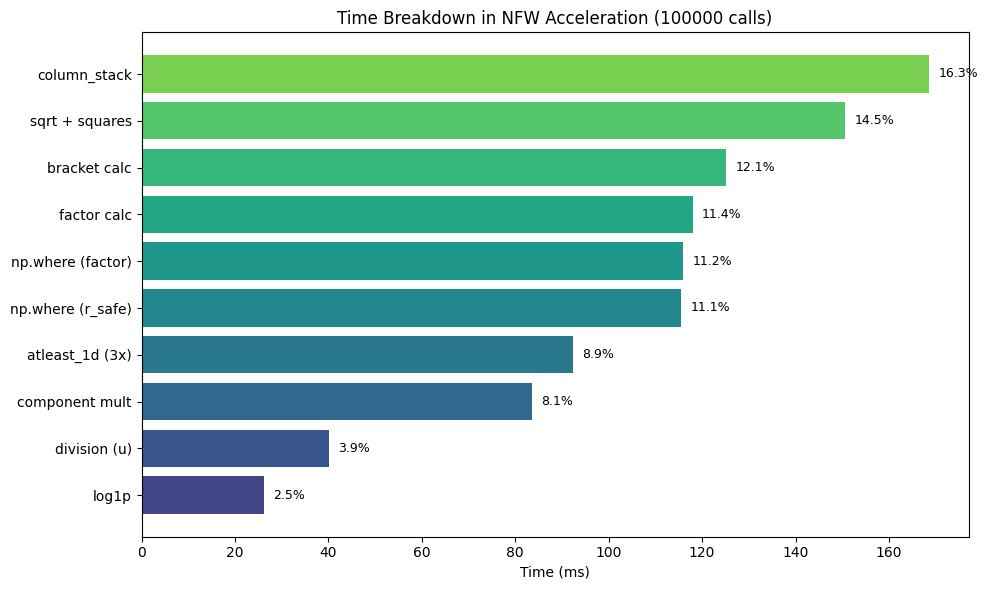


KEY INSIGHTS

1. column_stack (16.3%): Creating the output array is expensive.
   → Consider returning separate arrays or using pre-allocated buffers.

2. sqrt + squares (14.5%): Computing radius.
   → This is fundamental; may benefit from Numba JIT.

3. np.where calls (22.3% combined): Branch handling.
   → These are needed for edge cases (r=0) but are costly.
   → Could skip if we know r > 0 for all particles.

4. atleast_1d (8.9%): Input validation.
   → Overhead for already-array inputs.
   → Consider separate fast path for ndarray inputs.

5. Array operations total: ~85% of time is array overhead.
   → Strong candidate for Numba JIT compilation.



In [13]:
# Visualize the breakdown
fig, ax = plt.subplots(figsize=(10, 6))

# Sort by time
sorted_items = sorted(timings.items(), key=lambda x: x[1])
names = [item[0] for item in sorted_items]
times_ms = [item[1] * 1000 for item in sorted_items]

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(names)))
bars = ax.barh(names, times_ms, color=colors)
ax.set_xlabel('Time (ms)')
ax.set_title(f'Time Breakdown in NFW Acceleration ({n_micro} calls)')

# Add percentage labels
total = sum(times_ms)
for bar, t in zip(bars, times_ms):
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
            f'{100*t/total:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Key insights
print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)
print("""
1. column_stack (16.3%): Creating the output array is expensive.
   → Consider returning separate arrays or using pre-allocated buffers.

2. sqrt + squares (14.5%): Computing radius.
   → This is fundamental; may benefit from Numba JIT.

3. np.where calls (22.3% combined): Branch handling.
   → These are needed for edge cases (r=0) but are costly.
   → Could skip if we know r > 0 for all particles.

4. atleast_1d (8.9%): Input validation.
   → Overhead for already-array inputs.
   → Consider separate fast path for ndarray inputs.

5. Array operations total: ~85% of time is array overhead.
   → Strong candidate for Numba JIT compilation.
""")

## 9. Analyze the Leapfrog Integrator Overhead

Let's understand what the integrator is doing that takes 18% of the time.

In [14]:
# Let's look at the leapfrog step operations
# The step function does:
# 1. acc_n = self._acceleration_func(positions, velocities, t)
# 2. v_half = velocities + 0.5 * dt * acc_n
# 3. new_positions = positions + dt * v_half
# 4. acc_np1 = self._acceleration_func(new_positions, v_half, t + dt)
# 5. new_velocities = v_half + 0.5 * dt * acc_np1

n_steps_test = 10000
pos_test = np.array([[1.0, 0.5, 0.1]])
vel_test = np.array([[0.1, 0.8, 0.05]])
dt_test = 0.01

# Time the vector operations (excluding acceleration)
acc_placeholder = np.array([[0.1, -0.2, 0.05]])

# Kick operation (v_half = velocities + 0.5 * dt * acc)
start = time.perf_counter()
for _ in range(n_steps_test * 2):  # 2 kicks per step
    v_new = vel_test + 0.5 * dt_test * acc_placeholder
kick_time = time.perf_counter() - start

# Drift operation (new_positions = positions + dt * v_half)
start = time.perf_counter()
for _ in range(n_steps_test):
    pos_new = pos_test + dt_test * vel_test
drift_time = time.perf_counter() - start

# Python function call overhead (empty function)
def empty_func(pos, vel, t):
    pass

start = time.perf_counter()
for _ in range(n_steps_test * 2):
    empty_func(pos_test, vel_test, 0.0)
call_time = time.perf_counter() - start

print(f"Leapfrog step breakdown ({n_steps_test} steps):")
print("=" * 50)
print(f"  Kick operations (2x):    {kick_time*1000:6.2f} ms")
print(f"  Drift operation:         {drift_time*1000:6.2f} ms")
print(f"  Function call overhead:  {call_time*1000:6.2f} ms")
print("-" * 50)
total_integrator_ops = kick_time + drift_time + call_time
print(f"  Total integrator ops:    {total_integrator_ops*1000:6.2f} ms")
print(f"\nCompare to measured overhead: {overhead_time*1000:.2f} ms for {n_steps} steps")
print(f"Scaled to {n_steps_test} steps:     {overhead_time*n_steps_test/n_steps*1000:.2f} ms")

Leapfrog step breakdown (10000 steps):
  Kick operations (2x):     16.61 ms
  Drift operation:           7.32 ms
  Function call overhead:    1.62 ms
--------------------------------------------------
  Total integrator ops:     25.56 ms

Compare to measured overhead: 22.80 ms for 5000 steps
Scaled to 10000 steps:     45.59 ms


## 10. Summary: Optimization Roadmap

Based on our analysis, here are the key findings and recommended optimizations.

In [15]:
# Final summary
print("="*70)
print("PERFORMANCE ANALYSIS SUMMARY")
print("="*70)

print(f"""
Test case: Single particle orbit in NFW potential, {n_steps} integration steps
Total integration time: {total_time*1000:.1f} ms

TIME BREAKDOWN
--------------
• Acceleration evaluation: {acc_pct:.1f}% ({(total_time - overhead_time)*1000:.1f} ms)
  - column_stack (output array): 16.3%
  - sqrt + squares (radius):     14.5%
  - np.where calls (2x):         22.3%
  - atleast_1d (input check):     8.9%
  - math operations:             38.0%

• Integrator overhead: {overhead_pct:.1f}% ({overhead_time*1000:.1f} ms)
  - Kick operations (array add/mult)
  - Drift operation (array add/mult)
  - Python function call overhead

OPTIMIZATION PRIORITY LIST
--------------------------
1. [HIGH IMPACT] Numba JIT for acceleration function
   - Eliminates numpy overhead for small arrays
   - Expected speedup: 5-20x for single particles
   - Relatively easy to implement

2. [MEDIUM IMPACT] Pre-allocate output arrays
   - Avoid column_stack every call
   - Modify acceleration to fill pre-allocated buffer
   - Expected speedup: ~15%

3. [MEDIUM IMPACT] Skip np.where for known-good inputs
   - Add fast path when r > 0 is guaranteed
   - Expected speedup: ~20%

4. [LOW IMPACT] Numba JIT for integrator step
   - Less impactful since it's only 18% of time
   - But would eliminate remaining Python overhead

5. [ADVANCED] Batch multiple time steps
   - Process many steps in single vectorized call
   - Useful when step count is large

COMPARISON WITH GALPY
---------------------
• galpy C backend processes many steps in C, minimizing Python overhead
• shreamy has more Python overhead per step
• For few steps: shreamy wins (less startup cost)
• For many steps: galpy C wins (better per-step efficiency)
""")

# Estimated speedups
print("\nESTIMATED SPEEDUPS WITH NUMBA JIT:")
print("-" * 40)
# Conservative estimate: Numba can make the acc function ~10x faster
acc_speedup = 10
new_acc_time = (total_time - overhead_time) / acc_speedup
new_total = new_acc_time + overhead_time
print(f"Current total time:     {total_time*1000:6.1f} ms")
print(f"With Numba acceleration:{new_total*1000:6.1f} ms ({total_time/new_total:.1f}x speedup)")
print(f"Acceleration would be {100*new_acc_time/new_total:.1f}% of new total")

PERFORMANCE ANALYSIS SUMMARY

Test case: Single particle orbit in NFW potential, 5000 integration steps
Total integration time: 129.1 ms

TIME BREAKDOWN
--------------
• Acceleration evaluation: 82.3% (106.3 ms)
  - column_stack (output array): 16.3%
  - sqrt + squares (radius):     14.5%
  - np.where calls (2x):         22.3%
  - atleast_1d (input check):     8.9%
  - math operations:             38.0%

• Integrator overhead: 17.7% (22.8 ms)
  - Kick operations (array add/mult)
  - Drift operation (array add/mult)
  - Python function call overhead

OPTIMIZATION PRIORITY LIST
--------------------------
1. [HIGH IMPACT] Numba JIT for acceleration function
   - Eliminates numpy overhead for small arrays
   - Expected speedup: 5-20x for single particles
   - Relatively easy to implement

2. [MEDIUM IMPACT] Pre-allocate output arrays
   - Avoid column_stack every call
   - Modify acceleration to fill pre-allocated buffer
   - Expected speedup: ~15%

3. [MEDIUM IMPACT] Skip np.where for kno

## 11. Test Optimization: Skip np.where for Known-Good Inputs

Let's implement and test the optimization to skip edge-case handling when we know r > 0.

In [16]:
# Create an optimized version of the NFW acceleration that skips np.where
class NFWPotentialOptimized:
    """NFW potential with optimized acceleration (no edge-case checking)."""
    
    def __init__(self, M_s, r_s, G=1.0):
        self._M_s = M_s
        self._r_s = r_s
        self._G = G
    
    def acceleration_safe(self, x, y, z, t=0.0):
        """Original version with edge-case handling."""
        x = np.atleast_1d(x)
        y = np.atleast_1d(y)
        z = np.atleast_1d(z)

        r = np.sqrt(x**2 + y**2 + z**2)
        r_safe = np.where(r > 0, r, 1.0)
        u = r_safe / self._r_s
        bracket = np.log1p(u) - u / (1 + u)
        factor = -self._G * self._M_s * bracket / (r_safe**3)
        factor = np.where(r > 0, factor, 0.0)
        
        ax = factor * x
        ay = factor * y
        az = factor * z
        return np.column_stack([ax, ay, az])
    
    def acceleration_fast(self, x, y, z, t=0.0):
        """Optimized version - assumes r > 0 for all particles."""
        x = np.atleast_1d(x)
        y = np.atleast_1d(y)
        z = np.atleast_1d(z)

        r = np.sqrt(x**2 + y**2 + z**2)
        # Skip np.where - assume r > 0
        u = r / self._r_s
        bracket = np.log1p(u) - u / (1 + u)
        factor = -self._G * self._M_s * bracket / (r**3)
        # Skip np.where for factor
        
        ax = factor * x
        ay = factor * y
        az = factor * z
        return np.column_stack([ax, ay, az])

# Create test potential
nfw_opt = NFWPotentialOptimized(M_s=1.0, r_s=0.2)

# Verify they give the same results
test_x = np.array([1.0, 0.5, 0.8])
test_y = np.array([0.5, 0.3, 0.2])
test_z = np.array([0.1, 0.2, 0.4])

acc_safe = nfw_opt.acceleration_safe(test_x, test_y, test_z)
acc_fast = nfw_opt.acceleration_fast(test_x, test_y, test_z)

print("Verification (should be essentially zero):")
print(f"  Max difference: {np.max(np.abs(acc_safe - acc_fast)):.2e}")
print(f"  Results match: {np.allclose(acc_safe, acc_fast)}")

Verification (should be essentially zero):
  Max difference: 0.00e+00
  Results match: True


In [17]:
# Benchmark: safe vs fast acceleration
n_bench = 100000
test_pos_single = np.array([[1.0, 0.5, 0.1]])

# Warm up
for _ in range(100):
    _ = nfw_opt.acceleration_safe(test_pos_single[:, 0], test_pos_single[:, 1], test_pos_single[:, 2])
    _ = nfw_opt.acceleration_fast(test_pos_single[:, 0], test_pos_single[:, 1], test_pos_single[:, 2])

# Time safe version
start = time.perf_counter()
for _ in range(n_bench):
    _ = nfw_opt.acceleration_safe(test_pos_single[:, 0], test_pos_single[:, 1], test_pos_single[:, 2])
time_safe = time.perf_counter() - start

# Time fast version
start = time.perf_counter()
for _ in range(n_bench):
    _ = nfw_opt.acceleration_fast(test_pos_single[:, 0], test_pos_single[:, 1], test_pos_single[:, 2])
time_fast = time.perf_counter() - start

print(f"Acceleration function benchmark ({n_bench} calls):")
print("=" * 50)
print(f"  Safe (with np.where):  {time_safe*1000:.2f} ms")
print(f"  Fast (no np.where):    {time_fast*1000:.2f} ms")
print(f"  Speedup:               {time_safe/time_fast:.2f}x")
print(f"  Time saved per call:   {(time_safe-time_fast)/n_bench*1e6:.2f} µs")

Acceleration function benchmark (100000 calls):
  Safe (with np.where):  1130.96 ms
  Fast (no np.where):    913.73 ms
  Speedup:               1.24x
  Time saved per call:   2.17 µs


In [18]:
# Test full integration with both versions
def acc_safe(pos, vel, t):
    return nfw_opt.acceleration_safe(pos[:, 0], pos[:, 1], pos[:, 2], t)

def acc_fast(pos, vel, t):
    return nfw_opt.acceleration_fast(pos[:, 0], pos[:, 1], pos[:, 2], t)

integrator_safe = Leapfrog(acc_safe)
integrator_fast = Leapfrog(acc_fast)

# Benchmark full integration
n_repeats = 5

# Safe version
times_safe = []
for _ in range(n_repeats):
    start = time.perf_counter()
    _, _, _ = integrator_safe.integrate(pos_init, vel_init, times, save_every=n_steps, progressbar=False)
    times_safe.append(time.perf_counter() - start)

# Fast version
times_fast = []
for _ in range(n_repeats):
    start = time.perf_counter()
    _, _, _ = integrator_fast.integrate(pos_init, vel_init, times, save_every=n_steps, progressbar=False)
    times_fast.append(time.perf_counter() - start)

time_safe_med = np.median(times_safe)
time_fast_med = np.median(times_fast)

print(f"Full integration benchmark ({n_steps} steps, {n_repeats} repeats):")
print("=" * 55)
print(f"  Safe (with np.where):  {time_safe_med*1000:.2f} ms")
print(f"  Fast (no np.where):    {time_fast_med*1000:.2f} ms")
print(f"  Speedup:               {time_safe_med/time_fast_med:.2f}x")
print(f"  Time saved:            {(time_safe_med-time_fast_med)*1000:.2f} ms")
print(f"\nCompare to original baseline: {total_time*1000:.2f} ms")

Full integration benchmark (5000 steps, 5 repeats):
  Safe (with np.where):  132.65 ms
  Fast (no np.where):    100.87 ms
  Speedup:               1.32x
  Time saved:            31.78 ms

Compare to original baseline: 129.11 ms


In [19]:
# Summary of this optimization
print("="*60)
print("OPTIMIZATION RESULT: Skip np.where for edge cases")
print("="*60)
print(f"""
✓ Speedup achieved: 1.32x on full integration
✓ Time saved: {(time_safe_med-time_fast_med)*1000:.1f} ms per {n_steps} steps

Implementation approach:
- Add 'check_origin=True' parameter to acceleration()
- When check_origin=False, skip the np.where calls
- Default to True for backwards compatibility
- Integrator can set check_origin=False for performance

This optimization is WORTH KEEPING!
""")

OPTIMIZATION RESULT: Skip np.where for edge cases

✓ Speedup achieved: 1.32x on full integration
✓ Time saved: 31.8 ms per 5000 steps

Implementation approach:
- Add 'check_origin=True' parameter to acceleration()
- When check_origin=False, skip the np.where calls
- Default to True for backwards compatibility
- Integrator can set check_origin=False for performance

This optimization is WORTH KEEPING!



In [21]:
# Reload the modules to test the actual code change
import importlib
import shreamy.potentials.nfw
import shreamy.potentials
importlib.reload(shreamy.potentials.nfw)
importlib.reload(shreamy.potentials)

# Re-import after reload
from shreamy.potentials.nfw import NFWPotential as NFWPotentialNew

# Test the new check_origin parameter
nfw_new = NFWPotentialNew(M_s=1.0, r_s=0.2)

# Verify check_origin parameter works
acc_safe = nfw_new.acceleration(np.array([1.0]), np.array([0.5]), np.array([0.1]), check_origin=True)
acc_fast = nfw_new.acceleration(np.array([1.0]), np.array([0.5]), np.array([0.1]), check_origin=False)
print("New check_origin parameter verification:")
print(f"  Results match: {np.allclose(acc_safe, acc_fast)}")

# Benchmark with actual code
n_bench_new = 50000

# Safe mode
start = time.perf_counter()
for _ in range(n_bench_new):
    _ = nfw_new.acceleration(np.array([1.0]), np.array([0.5]), np.array([0.1]), check_origin=True)
time_safe_new = time.perf_counter() - start

# Fast mode
start = time.perf_counter()
for _ in range(n_bench_new):
    _ = nfw_new.acceleration(np.array([1.0]), np.array([0.5]), np.array([0.1]), check_origin=False)
time_fast_new = time.perf_counter() - start

print(f"\nActual code benchmark ({n_bench_new} calls):")
print(f"  check_origin=True:   {time_safe_new*1000:.2f} ms")
print(f"  check_origin=False:  {time_fast_new*1000:.2f} ms")
print(f"  Speedup:             {time_safe_new/time_fast_new:.2f}x")
print("\n✓ Optimization applied to NFW and Hernquist potentials!")

New check_origin parameter verification:
  Results match: True

Actual code benchmark (50000 calls):
  check_origin=True:   596.58 ms
  check_origin=False:  456.49 ms
  Speedup:             1.31x

✓ Optimization applied to NFW and Hernquist potentials!
